In [139]:
!pip install --upgrade mido numpy pandas matplotlib enlighten

import mido
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import enlighten
import os
from pathlib import Path

# Load metadata
df = pd.read_csv("maestro-v3.0.0/maestro-v3.0.0.csv")

# New metadata column for absolute file paths, ChatGPT
df["midi_path"] = df["midi_filename"].apply(
    lambda p: Path("maestro-v3.0.0") / p
)

# Split data. Validate possibly unnecessary
df_train = df[df["split"] == "train"].head(100) # 962 elements, grab first 100
df_validate = df[df["split"] == "validation"] # 137 elements
df_test  = df[df["split"] == "test"] # 177 elements

In [140]:
def extract_sustain_curve(midi):
    curve = []
    time_s = 0

    for msg in midi:
        time_s += msg.time
        # control=64 indicates sustain pedal
        if msg.type == "control_change" and msg.control == 64:
            # Append current time and pedal value
            curve.append((time_s, msg.value))
    return curve

In [141]:
def pedal_to_binary(values, threshold):
    values = np.asarray(values)
    return (values > threshold).astype(int)

In [142]:
# Simple interval dissonance lookup
INTERVAL_DISSONANCE = {
    0: 0,   1: 4,  2: 4,
    3: 2,   4: 2,  5: 3,
    6: 5,   7: 1,
    8: 2,   9: 2,
    10: 4, 11: 4,
    12: 0
}

def interval_dissonance(n1, n2):
    interval = abs(n1 - n2) % 12
    return INTERVAL_DISSONANCE.get(interval, 0)

def instantaneous_dissonance(midi, pedal_threshold=64):
    """
    Computes instantaneous harmonic dissonance across the entire MIDI,
    correctly accounting for sustain pedal behavior.

    sounding_notes = notes currently heard (finger-held + pedal-held)
    finger_held    = notes currently pressed by fingers (note_on without corresponding note_off)

    Dissonance at each event = sum of interval dissonances among all sounding notes.
    """
    times = []
    diss_curve = []

    current_time = 0
    pedal_down = False

    sounding_notes = set()
    finger_held = set()

    def total_dissonance(notes):
        """Sum dissonances for all unique unordered pairs of notes."""
        if len(notes) < 2:
            return 0
        notes = list(notes)
        d = 0
        for i in range(len(notes)):
            for j in range(i + 1, len(notes)):
                d += interval_dissonance(notes[i], notes[j])
        return d

    for msg in midi:
        current_time += msg.time

        # --- PEDAL EVENTS ---
        if msg.type == "control_change" and msg.control == 64:
            was_down = pedal_down
            pedal_down = msg.value > pedal_threshold

            # Pedal lifted → keep only finger-held notes
            if was_down and not pedal_down:
                sounding_notes = set(finger_held)

        # --- NOTE ON ---
        if msg.type == "note_on" and msg.velocity > 0:
            finger_held.add(msg.note)
            sounding_notes.add(msg.note)

        # --- NOTE OFF ---
        if msg.type == "note_off" or (msg.type == "note_on" and msg.velocity == 0):
            if msg.note in finger_held:
                finger_held.remove(msg.note)

            # When pedal is up, note is no longer sounding
            if not pedal_down and msg.note in sounding_notes:
                sounding_notes.remove(msg.note)

        # --- Compute instantaneous dissonance ---
        diss = total_dissonance(sounding_notes)

        times.append(current_time)
        diss_curve.append(diss)

    return np.array(times), np.array(diss_curve)

In [143]:
def cumulative_dissonance(midi_path, tau, fps=50):
    """
    Pedal default: down.
    Accumulate dissonance over time.
    Release pedal momentarily when accumulation exceeds tau.
    Returns: t_grid, ped_pred (0/1), dissonance resampled, accum over time
    """
    midi = mido.MidiFile(midi_path)

    # Dissonance curve
    diss_times, diss_vals = instantaneous_dissonance(midi)
    t_grid, diss_res = resample_curve(diss_times, diss_vals, fps=fps)

    ped_pred = np.ones_like(diss_res, dtype=int)  # start pedal down
    accum = 0
    accum_vals = np.zeros_like(diss_res)

    for i, d in enumerate(diss_res):
        accum += d
        accum_vals[i] = accum
        if accum > tau:
            ped_pred[i] = 0  # release pedal for one frame
            accum = 0        # reset accumulation

    return t_grid, ped_pred, diss_res, accum_vals

In [144]:
def resample_curve(times, values, fps=50):
    """
    Given irregular event times/values (like pedal or dissonance),
    resample to a regular FPS grid using forward-fill interpolation.
    """
    times = np.asarray(times)
    values = np.asarray(values)

    t_end = times[-1]
    t_grid = np.arange(0, t_end, 1.0 / fps)

    # For each grid time, find the last event time <= t
    idx = np.searchsorted(times, t_grid, side="right") - 1
    idx[idx < 0] = 0

    return t_grid, values[idx]

def get_release_dissonances(midi_path, pedal_threshold=64, fps=50):
    midi = mido.MidiFile(midi_path)

    # Pedal curve (irregular)
    ped_times, ped_vals = zip(*extract_sustain_curve(midi))
    ped_vals = np.array(ped_vals)
    ped_binary = pedal_to_binary(ped_vals, pedal_threshold)

    # Dissonance curve (irregular)
    diss_times, diss_vals = instantaneous_dissonance(midi)

    # Resample both to same grid
    t_ped, ped_res = resample_curve(ped_times, ped_binary, fps=fps)
    t_diss, diss_res = resample_curve(diss_times, diss_vals, fps=fps)

    # Identify release moments: 1 → 0
    release_indices = np.where((ped_res[:-1] == 1) & (ped_res[1:] == 0))[0]

    # Get dissonance values right at release frames
    return diss_res[release_indices]

In [145]:
### Training

all_release_diss = []

# Don't worry about warning, maybe
manager = enlighten.get_manager()
pbar = manager.counter(total=len(df_train), desc='Processing MIDI files', unit='file')

for _, row in df_train.iterrows():
    try:
        vals = get_release_dissonances(row["midi_path"])
        if len(vals) > 0:
            all_release_diss.extend(vals)
    except Exception as e:
        print("Error:", row["midi_path"], e)
    finally:
        pbar.update()

all_release_diss = np.array(all_release_diss)

tau = np.median(all_release_diss)
print("Learned pedal-release threshold τ =", tau)
manager.stop()

C:\Code\machine_learning_final_project\.venv\Lib\site-packages\blessed\terminal.py:235: UserWarning: A terminal of kind "xterm-256color" has been requested; due to an internal python curses bug, terminal capabilities for a terminal of kind "xterm" will continue to be returned for the remainder of this process.
  warnings.warn(


Learned pedal-release threshold τ = 56.0


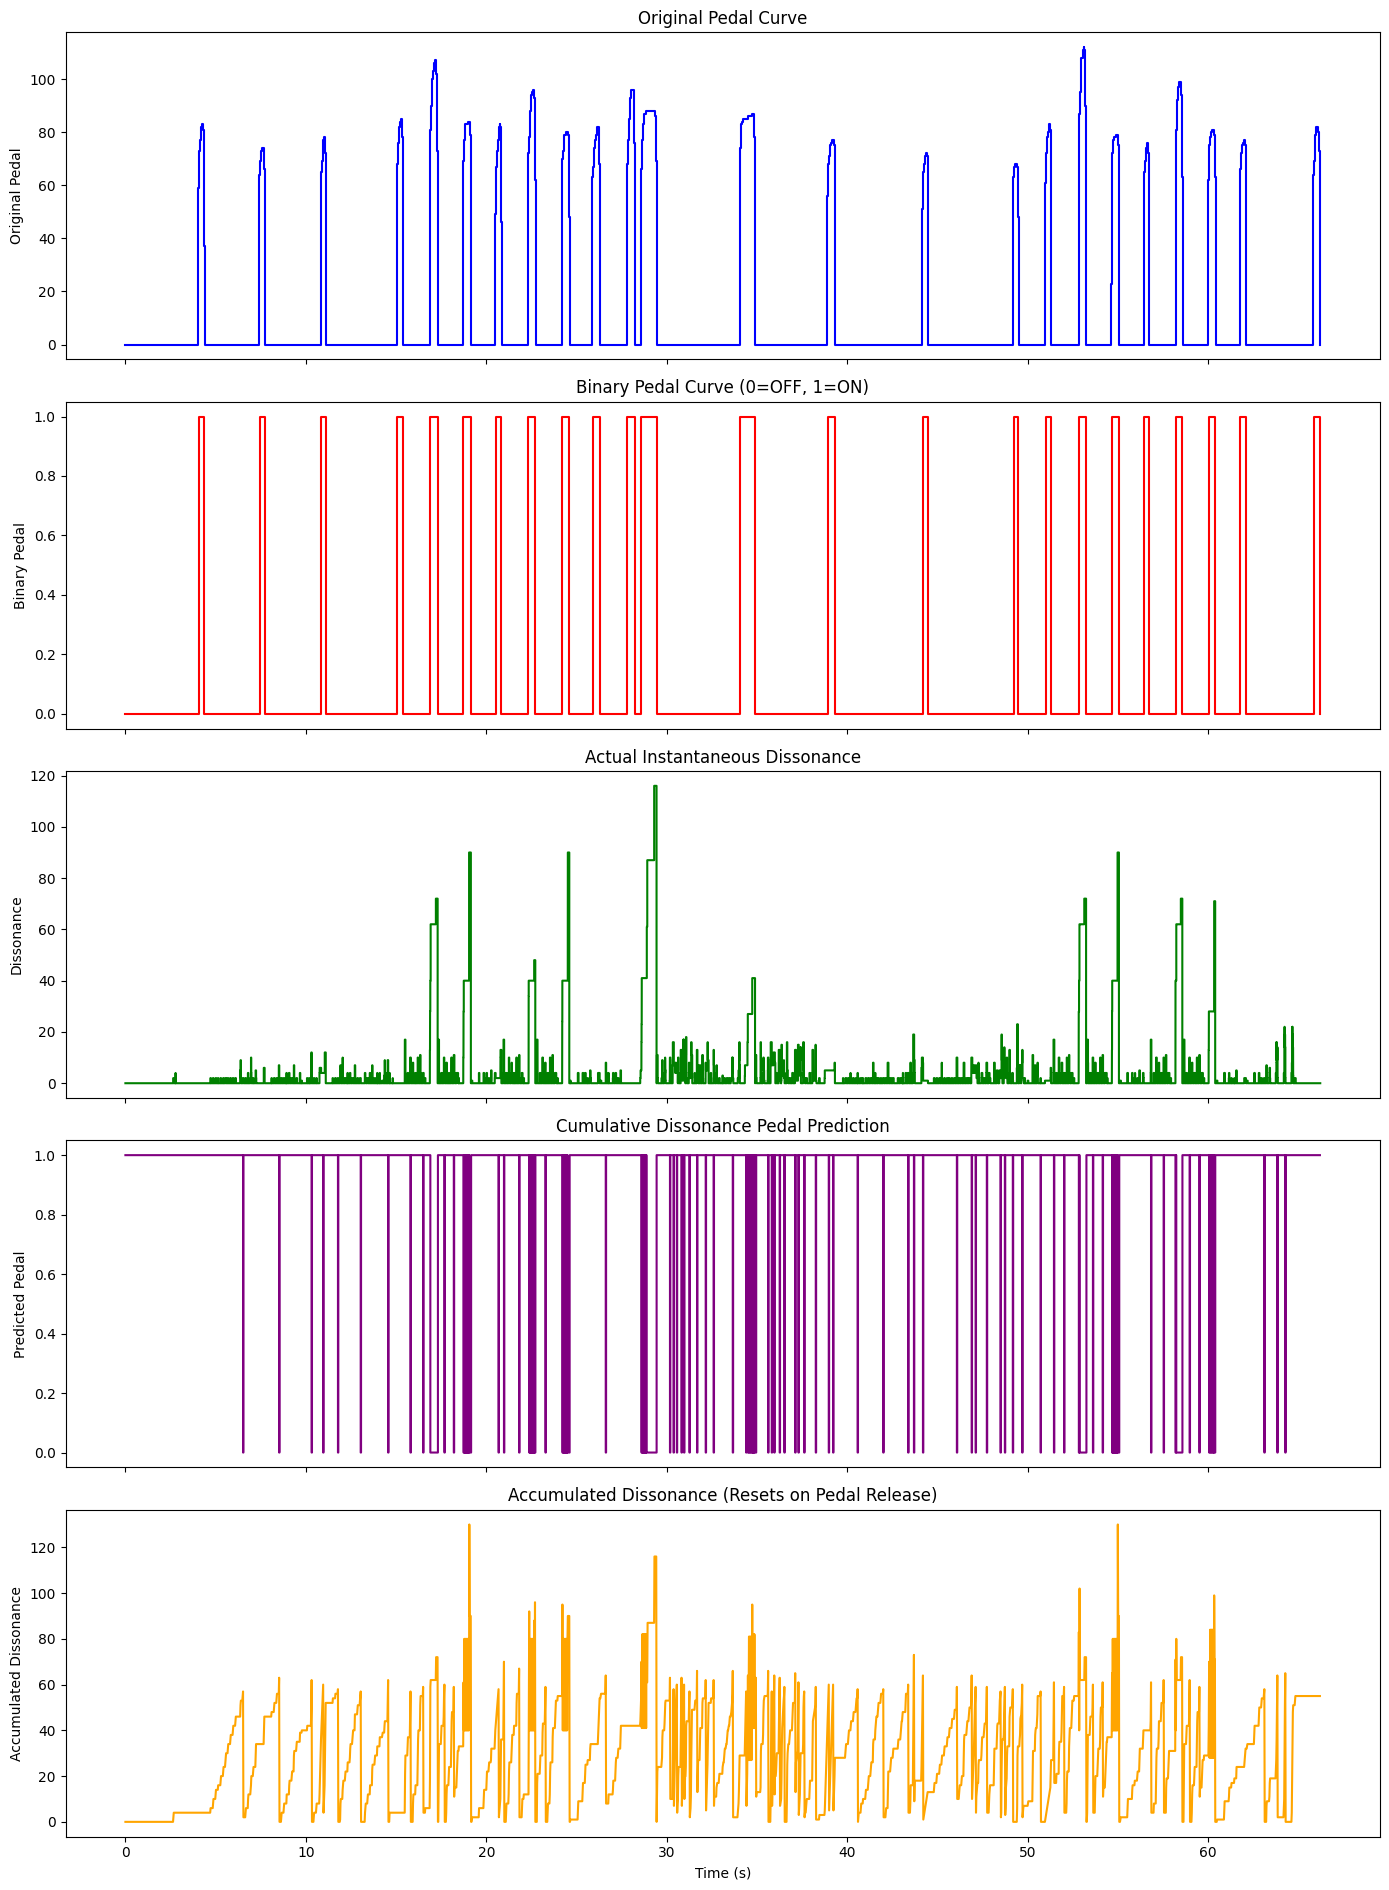

In [146]:
# https://www.youtube.com/watch?v=kzhLlNhgJT0
sample = df_test.iloc[14]["midi_path"]

# --- Extract curves ---
midi = mido.MidiFile(sample)

# Original pedal
ped_times, ped_values = zip(*extract_sustain_curve(midi))
ped_values = np.array(ped_values)
ped_binary = pedal_to_binary(ped_values, threshold=64)

# Instantaneous dissonance
diss_times, diss_values = instantaneous_dissonance(midi)

# Predicted pedal via cumulative dissonance
t_grid, ped_pred, diss_resampled, accum_vals = cumulative_dissonance(sample, tau=tau)

# --- Plot ---
fig, axs = plt.subplots(5, 1, figsize=(14, 19), sharex=True)

axs[0].step(ped_times, ped_values, where='post', color='blue')
axs[0].set_ylabel("Original Pedal")
axs[0].set_title("Original Pedal Curve")

axs[1].step(ped_times, ped_binary, where='post', color='red')
axs[1].set_ylabel("Binary Pedal")
axs[1].set_title("Binary Pedal Curve (0=OFF, 1=ON)")

axs[2].step(diss_times, diss_values, where='post', color='green')
axs[2].set_ylabel("Dissonance")
axs[2].set_title("Actual Instantaneous Dissonance")

axs[3].step(t_grid, ped_pred, where='post', color='purple')
axs[3].set_ylabel("Predicted Pedal")
axs[3].set_title("Cumulative Dissonance Pedal Prediction")

axs[4].plot(t_grid, accum_vals, color='orange')
axs[4].set_ylabel("Accumulated Dissonance")
axs[4].set_xlabel("Time (s)")
axs[4].set_title("Accumulated Dissonance (Resets on Pedal Release)")

plt.tight_layout()
plt.show()